# Sentiment analysis in film reviews

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.datasets import load_files
moviedir = r'./dataset/movie_reviews' 
movie_reviews = load_files(moviedir, shuffle=True)
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [2]:
# movie_reviews.data has the reviews and movies.target its sentiment.

print("Tenemos {} reviews, con clases {},".format(len(movie_reviews.data), movie_reviews.target_names))

Tenemos 2000 reviews, con clases ['neg', 'pos'],


In [3]:
# Sample data

movie_reviews.data[0][:500]

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so cal"

In [4]:
movie_reviews.target[0]

0

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    movie_reviews.data, 
    movie_reviews.target, 
    test_size = 0.20, 
    stratify=movie_reviews.target, 
    random_state = 12)

In [6]:
# Vec of dataset

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train, y_train)
X_test = vectorizer.transform(X_test, y_test)

In [7]:
print("number of documents: ",X_train.shape[0])
print("number of words in corpus: ",X_train.shape[1])

number of documents:  1600
number of words in corpus:  36342


## Training models

### Support Vector Machines (SVM)

In [8]:
#Lineal Kernel for SVM, because there are more features than instances.

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10],
}

supvec = SVC(kernel='linear',probability=True)
clf = GridSearchCV(supvec, param_grid, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [9]:
pd.DataFrame(clf.cv_results_).sort_values(by='mean_test_score',ascending=False)[['params','rank_test_score','mean_test_score']]

,params,rank_test_score,mean_test_score
4,{'C': 10},1,0.922000
3,{'C': 1},2,0.921453
0,{'C': 0.001},3,0.855789
1,{'C': 0.01},3,0.855789
2,{'C': 0.1},3,0.855789


In [10]:
clf.best_params_

{'C': 10}

In [11]:
clf.best_score_

0.9220000000000002

In [12]:
optimized_svm = clf.best_estimator_

In [13]:
optimized_svm.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
# function to graph a confusion matrix

import numpy as np
import itertools
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Normalized confusion matrix
[[0.815 0.185]
 [0.16  0.84 ]]


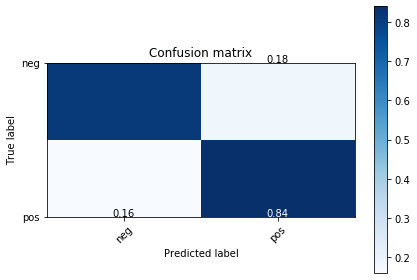

In [15]:
# predicting to plot the confusion matrix

pred = optimized_svm.predict(X_test)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, movie_reviews.target_names,normalize=True)

In [16]:
# roc_auc score & classification_report

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

roc = roc_auc_score(y_test, pred)
print('AUC:',roc)
cr=classification_report(y_test,pred)
print(cr)

AUC: 0.8274999999999999
             precision    recall  f1-score   support

          0       0.84      0.81      0.83       200
          1       0.82      0.84      0.83       200

avg / total       0.83      0.83      0.83       400



### RandomForestClassifier

In [17]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

param_grid_2 = {
    'n_estimators' : [100, 500, 1000],
    'max_depth' : [3, 7, None],
    'min_samples_split' : [2, 3, 10],
    'bootstrap' : [True, False],
    'criterion' : ["gini", "entropy"]   
}

model = GridSearchCV(rfc, param_grid_2, cv=5, scoring='roc_auc')
model.fit(X_train, y_train)

/home/horacio/anaconda3/envs/proy77/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 500, 1000], 'max_depth': [3, 7, None], 'min_samples_split': [2, 3, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [18]:
pd.DataFrame(model.cv_results_).sort_values(by='mean_test_score',ascending=False)[['params','rank_test_score','mean_test_score']]

,params,rank_test_score,mean_test_score
101,"{'bootstrap': False, 'criterion': 'entropy', '...",1,0.902895
107,"{'bootstrap': False, 'criterion': 'entropy', '...",2,0.898602
104,"{'bootstrap': False, 'criterion': 'entropy', '...",3,0.898551
103,"{'bootstrap': False, 'criterion': 'entropy', '...",4,0.897605
106,"{'bootstrap': False, 'criterion': 'entropy', '...",5,0.897273
...,...,...,...
81,"{'bootstrap': False, 'criterion': 'entropy', '...",104,0.842047
30,"{'bootstrap': True, 'criterion': 'entropy', 'm...",105,0.841133
3,"{'bootstrap': True, 'criterion': 'gini', 'max_...",106,0.832695
0,"{'bootstrap': True, 'criterion': 'gini', 'max_...",107,0.829688


In [19]:
model.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [20]:
model.best_score_

0.90289453125

In [21]:
optimized_rt = model.best_estimator_

In [22]:
pred_rf = optimized_rt.predict(X_test)

In [23]:
roc_rf = roc_auc_score(y_test, pred_rf)

In [24]:
print('AUC:',roc_rf)
cr=classification_report(y_test,pred_rf)
print(cr)

AUC: 0.8225
             precision    recall  f1-score   support

          0       0.79      0.87      0.83       200
          1       0.86      0.78      0.81       200

avg / total       0.83      0.82      0.82       400



Normalized confusion matrix
[[0.87  0.13 ]
 [0.225 0.775]]


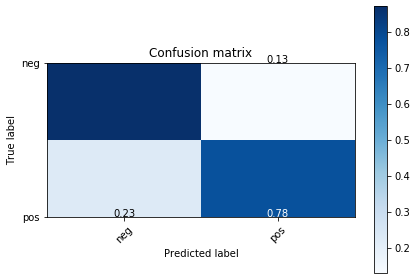

In [25]:
cm_rf=confusion_matrix(y_test, pred_rf)
plot_confusion_matrix(cm_rf, movie_reviews.target_names,normalize=True)

### Multilayer Perceptron

In [26]:
from sklearn.neural_network import MLPClassifier

mlc = MLPClassifier()

param_grid_2 = {
    'hidden_layer_sizes': [(10,),(5,5), (2,2)]
}

grid_ml = GridSearchCV(mlc, param_grid_2, cv=5, scoring='roc_auc')
grid_ml.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(10,), (5, 5), (2, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [27]:
grid_ml.best_params_

{'hidden_layer_sizes': (10,)}

In [28]:
grid_ml.best_score_

0.915609375

In [29]:
opt_ml = grid_ml.best_estimator_

In [30]:
opt_ml.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [31]:
pred_ml = opt_ml.predict(X_test)

In [32]:
roc_ml = roc_auc_score(y_test,pred_ml)
print('AUC:',roc_ml)
cr_ml = classification_report(y_test,pred_rf)
print(cr_ml)

AUC: 0.85
             precision    recall  f1-score   support

          0       0.79      0.87      0.83       200
          1       0.86      0.78      0.81       200

avg / total       0.83      0.82      0.82       400



Normalized confusion matrix
[[0.835 0.165]
 [0.135 0.865]]


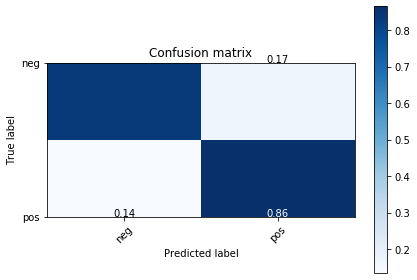

In [33]:
cm_ml=confusion_matrix(y_test, pred_ml)
plot_confusion_matrix(cm_ml, movie_reviews.target_names,normalize=True)

### AdaBoost

In [34]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()

pg = {
    'n_estimators' : [50,100,500]
}

grid_ada = GridSearchCV(ada, pg, cv=5, scoring='roc_auc')

In [35]:
grid_ada.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [36]:
grid_ada.best_params_

{'n_estimators': 500}

In [37]:
grid_ada.best_score_

0.8664140625000001

In [38]:
opt_ada = grid_ada.best_estimator_

In [39]:
opt_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=500, random_state=None)

In [40]:
pred_ada = opt_ada.predict(X_test)

In [41]:
roc_ada = roc_auc_score(y_test,pred_ada)
print('AUC:',roc_ada)
cr_ada = classification_report(y_test,pred_ada)
print(cr_ada)

AUC: 0.7999999999999999
             precision    recall  f1-score   support

          0       0.79      0.81      0.80       200
          1       0.81      0.79      0.80       200

avg / total       0.80      0.80      0.80       400



Normalized confusion matrix
[[0.815 0.185]
 [0.215 0.785]]


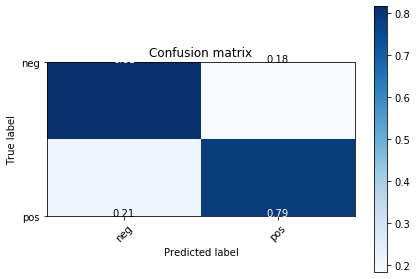

In [42]:
mc_ada = confusion_matrix(y_test, pred_ada)
plot_confusion_matrix(mc_ada, movie_reviews.target_names,normalize=True)

### Ensemble: VotingCLassifier

In [43]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[
    ('r_tree',optimized_rt), ('mlp',opt_ml), ('ada',opt_ada), ('svm',optimized_svm)],
    voting='soft')

eclf.fit(X_train,y_train)

VotingClassifier(estimators=[('r_tree', RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [46]:
eclf.estimators_

[RandomForestClassifier(bootstrap=False, class_weight=None,
             criterion='entropy', max_depth=None, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_jobs=1, oob_score=False,
             random_state=None, verbose=0, warm_start=False),
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(10,), learning_rate='constant',
        learning_rate_init=0.001, max_iter=200, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=False, warm_start=False),
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=500, random_state=N

In [61]:
eclf.score(X_test, y_test)

0.86

In [60]:
from sklearn.metrics import accuracy_score

pred_svm = optimized_svm.predict(X_test)
pred_mlp = opt_ml.predict(X_test)
pred_rt = optimized_rt.predict(X_test)
pred_ada = opt_ada.predict(X_test)
pred_eclf = eclf.predict(X_test)
scoreSVM = accuracy_score(pred_svm,y_test)
scoreMLP = accuracy_score(pred_mlp,y_test)
scoreRT = accuracy_score(pred_rt,y_test)
scoreADA = accuracy_score(pred_ada,y_test)
scoreE = accuracy_score(pred_eclf,y_test)
print(scoreSVM,scoreMLP,scoreRT,scoreADA,scoreE)

0.8275 0.85 0.8225 0.8 0.86


In [49]:
import pickle

filename = 'sentiment.pkl'
pickle.dump(eclf, open(filename, 'wb'))

In [59]:
pred_clf = eclf.predict(X_test)

In [51]:
from sklearn.metrics import roc_auc_score

scores = roc_auc_score(pred_clf,y_test)
scores

0.8603242918626763

Checking how model performs in a [review of "Rocky 4"](https://www.rottentomatoes.com/m/rocky_iv/reviews/?type=user).

In [52]:
reviews_new = ["Stallone creates credible villains worthy of his heroic character.",
               "Another brilliant Rocky film, probably my favourite one out of the lot",
               "Yeah, this movie sucks.",
               "My favourite rocky film! So good so much heart. Slightly better than 2",
               "What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!",
               "The new film's narrative is stripped down to essentials, which gives it an emblematic quality.",
               "Absurdly ridiculous, this just isn't a good movie at all", 
               "Very basic and predictable but still an okay movie. No special music to save this one.", 
              "Rocky 4 is an extremely ambitious movie that is definitely worth watching.",
              'Highly beautiful',
               "If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would otherwise be nothing more than an interminable series of mildly rousing montages. There are some unintentionally funny bits though, and Dolph's Ivan showcases the best and worst of all Rocky's opponents.",
              "While all aspects of realism is thrown out the window, ROCKY IV is an adrenaline rush of action and excitment, with an incredible soundtrack and arguably the best movie fight in history between Balboa and Drago",
              "Just like the songs, exercise routines and repetitive clips, it seems redundant to add another installment in this already falling franchise when you clearly lack material. Rocky IV is petty, childish and seems overlong despite of its 91 minutes of run time for it merely has an idea of a TV drama episode which is stretched to a point of exhaustion. Its painful to watch Sylvester Stallone go through this enormous amount of training and hardly make a point out there. He fails on all the levels here; writer, director and actor, to deliver any loose end of the thread for the audience to hang on to. Rocky IV is predictable, loosely written and choreographed and executed unsupervised."]

In [53]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [54]:
reviews_new_tfidf = vectorizer.transform(reviews_new)

In [58]:
pred = eclf.predict(reviews_new_tfidf)

In [56]:
for review, category in zip(reviews_new, pred):
    print('%r => %s \n' % (review, movie_reviews.target_names[category]))

'Stallone creates credible villains worthy of his heroic character.' => neg 

'Another brilliant Rocky film, probably my favourite one out of the lot' => pos 

'Yeah, this movie sucks.' => neg 

'My favourite rocky film! So good so much heart. Slightly better than 2' => pos 

'What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!' => neg 

"The new film's narrative is stripped down to essentials, which gives it an emblematic quality." => neg 

"Absurdly ridiculous, this just isn't a good movie at all" => neg 

'Very basic and predictable but still an okay movie. No special music to save this one.' => neg 

'Rocky 4 is an extremely ambitious movie that is definitely worth watching.' => pos 

'Highly beautiful' => pos 

"If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would oth